# Logistic Regression and Feature Selection

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from boruta import BorutaPy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(columns='died')
X_test = test.drop(columns='died')
y_train = train.died
y_test = test.died

We will use logistic regression as a baseline using attributes from the patient baseline table including variables related to patient demographics and admission and discharge details for the ICU stay. Then, we will progressively add subsets of variables to see if there is any improvement.

### Baseline Logistic Regression Model with patient variables

In [3]:
selected_cols = ['admissionheight', 'admissionweight', 'dischargeweight', 
                 'icuduration', 'weightdiffafterdischarge', 'gendermale', 
                 'age0-9', 'age10-19', 'age20-29', 'age30-39', 'age40-49', 
                 'age50-59', 'age60-69', 'age>89', 'ethnicity_African American', 
                 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 
                 'ethnicity_Native American', 'ethnicity_Other/Unknown', 
                 'hospitaladmitsource_Acute Care/Floor',
                 'hospitaladmitsource_Chest Pain Center',
                 'hospitaladmitsource_Direct Admit',
                 'hospitaladmitsource_Emergency Department', 
                 'hospitaladmitsource_Floor', 'hospitaladmitsource_ICU', 
                 'hospitaladmitsource_ICU to SDU', 
                 'hospitaladmitsource_Observation', 
                 'hospitaladmitsource_Operating Room', 
                 'hospitaladmitsource_Other',
                 'hospitaladmitsource_Other Hospital', 
                 'hospitaladmitsource_Other ICU', 'hospitaladmitsource_PACU',
                 'hospitaladmitsource_Recovery Room',
                 'hospitaladmitsource_Step-Down Unit (SDU)', 
                 'dischargehour8-14', 'unittype_CCU-CTICU', 'unittype_CSICU', 
                 'unittype_CTICU', 'unittype_Cardiac ICU', 'unittype_MICU', 
                 'unittype_Med-Surg ICU', 'unittype_Neuro ICU', 'unittype_SICU',
                 'unitadmitsource_Acute Care/Floor', 
                 'unitadmitsource_Chest Pain Center', 
                 'unitadmitsource_Direct Admit', 
                 'unitadmitsource_Emergency Department', 
                 'unitadmitsource_Floor', 'unitadmitsource_ICU', 
                 'unitadmitsource_ICU to SDU', 'unitadmitsource_Observation', 
                 'unitadmitsource_Operating Room', 'unitadmitsource_Other', 
                 'unitadmitsource_Other Hospital', 'unitadmitsource_Other ICU', 
                 'unitadmitsource_PACU', 'unitadmitsource_Recovery Room', 
                 'unitadmitsource_Step-Down Unit (SDU)']

X_train_patient = X_train.loc[:, selected_cols]
X_test_patient = X_test.loc[:, selected_cols]

In [4]:
lr_base = LogisticRegression(penalty='none',
                             max_iter=1000).fit(X_train_patient, y_train)
train_auc = roc_auc_score(y_train, lr_base.predict_proba(X_train_patient)[:, 1])
test_auc = roc_auc_score(y_test, lr_base.predict_proba(X_test_patient)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

0.713
0.688


### Logistic Regression with APACHE prediction data and data on other patient conditions added

In [5]:
selected_cols.extend(['meanapachescore','meanpredictedicumortality', 
                      'meanpredictediculos', 'immunosuppression', 'diabetes',
                      'intubated', 'vent', 'dialysis', 'urine', 'wbc', 
                      'temperature', 'respiratoryrate', 'sodium', 'heartrate',
                      'meanbp', 'creatinine', 'glucose', 'bun'])

X_train_2 = X_train.loc[:, selected_cols]
X_test_2 = X_test.loc[:, selected_cols]

In [6]:
lr_mod_2 = LogisticRegression(penalty='none',
                              max_iter=1000).fit(X_train_2, y_train)
train_auc = roc_auc_score(y_train, lr_mod_2.predict_proba(X_train_2)[:, 1])
test_auc = roc_auc_score(y_test, lr_mod_2.predict_proba(X_test_2)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

0.796
0.776


### Logistic Regression with hospital attributes added

In [7]:
selected_cols.extend(['numbedscategory_100 - 249', 'numbedscategory_250 - 499',
                      'numbedscategory_<100', 'numbedscategory_>= 500',
                      'hospitalregion_Midwest', 'hospitalregion_Northeast',
                      'hospitalregion_South', 'hospitalregion_West'])

X_train_3 = X_train.loc[:, selected_cols]
X_test_3 = X_test.loc[:, selected_cols]

In [8]:
lr_mod_3 = LogisticRegression(penalty='none').fit(X_train_3, y_train)
train_auc = roc_auc_score(y_train, lr_mod_3.predict_proba(X_train_3)[:, 1])
test_auc = roc_auc_score(y_test, lr_mod_3.predict_proba(X_test_3)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

0.767
0.767


### Logistic Regression with vital sign attributes added

In [9]:
lr_mod_4 = LogisticRegression(penalty='none',
                              max_iter=1000).fit(X_train, y_train)
train_auc = roc_auc_score(y_train, lr_mod_4.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, lr_mod_4.predict_proba(X_test)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

0.825
0.811


##### Check linearity of numeric variables with log-odds

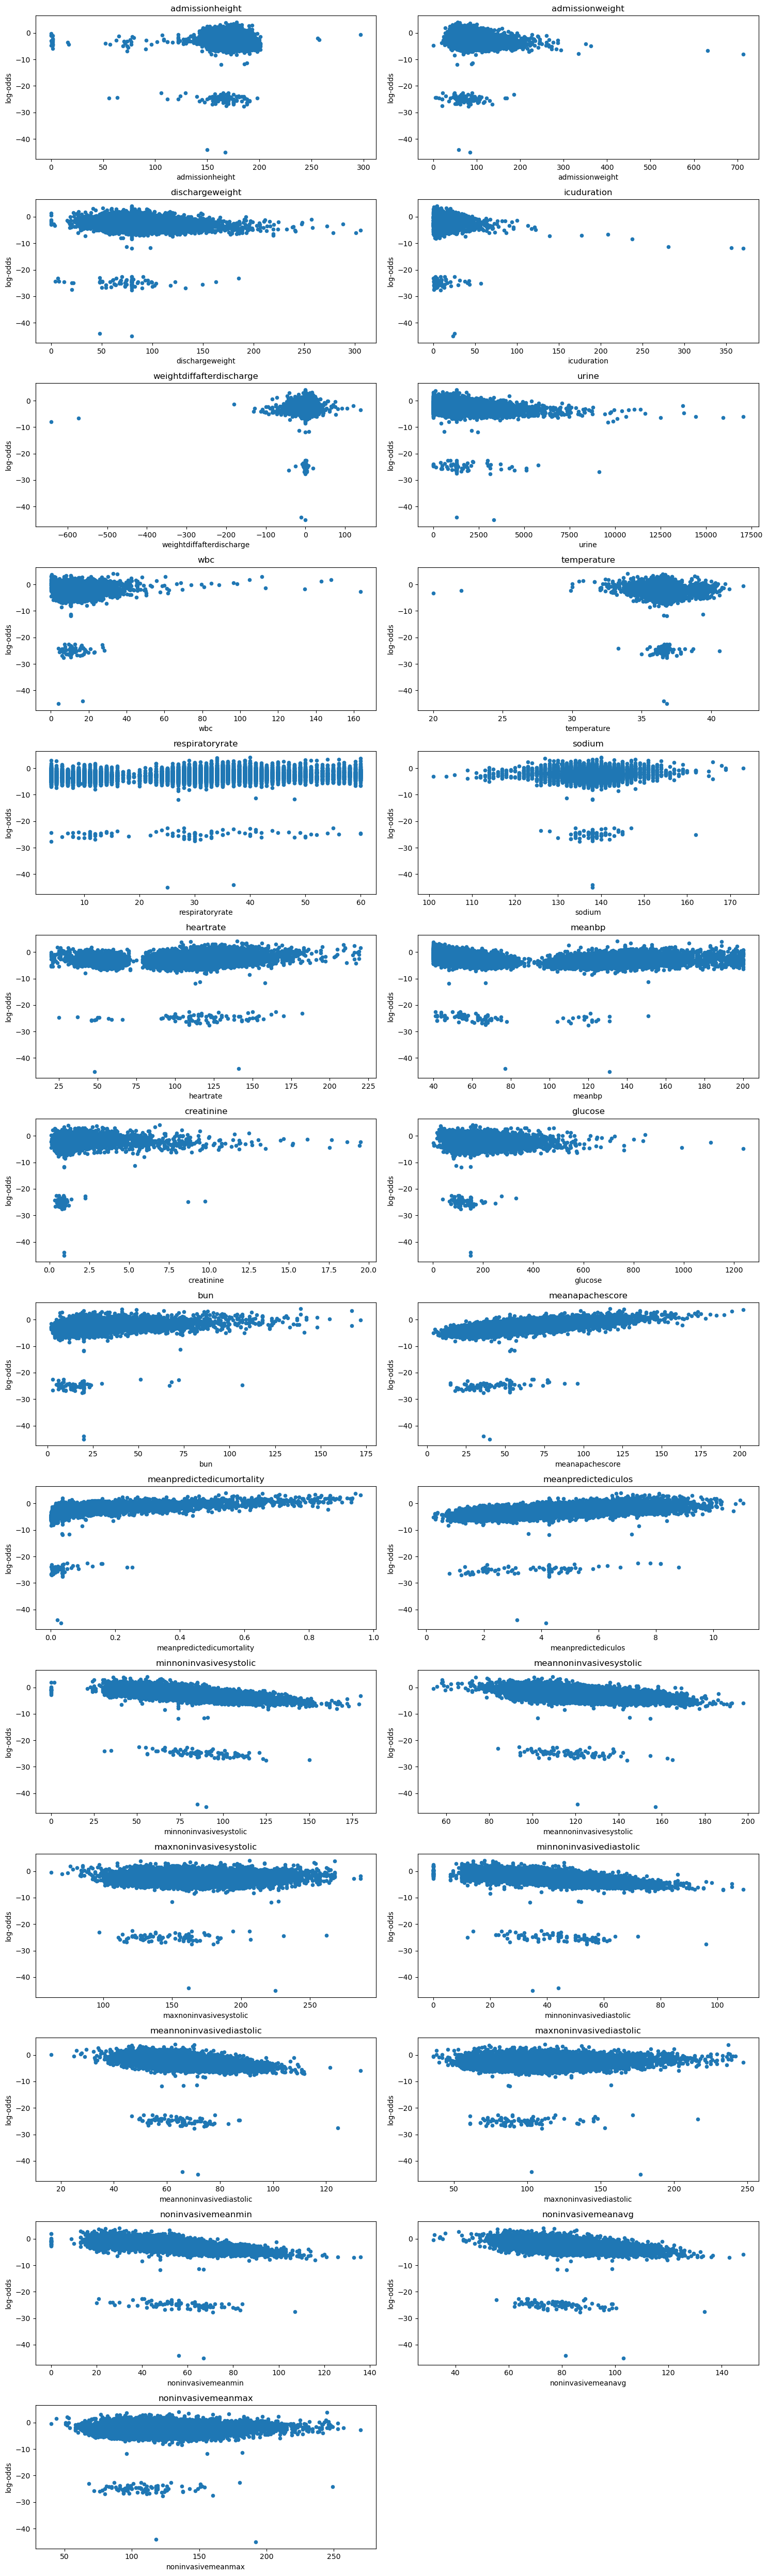

In [10]:
X = sm.add_constant(X_train, prepend=False)

logit_results = sm.GLM(y_train, X, family=sm.families.Binomial()).fit()
predicted = logit_results.predict(X)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))
X['log_odds'] = log_odds

vars_to_exclude = [col for col in X.columns if X[col].nunique() <= 2]
vars_to_exclude.extend(['log_odds'])
numeric_vars = [col for col in X.columns if col not in vars_to_exclude]

fig=plt.figure(figsize=(15,50))
for i, var_name in enumerate(numeric_vars): 
    ax=fig.add_subplot(14, 2, i+1)
    ax=plt.gca()
    X.plot.scatter(x=var_name, y='log_odds', ax=ax)
    ax.set(xlabel=var_name, ylabel='log-odds')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

None of the numeric variables appear to be linear with the log-odds.

### Logistic Regression with lasso penalty

In [11]:
param_grid = {'logit__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    
components = [('scaler', StandardScaler()), 
              ('logit', LogisticRegression(penalty='l1',
                                           solver='liblinear'))]

pipe = Pipeline(components)
grid = GridSearchCV(pipe, param_grid, scoring='roc_auc')

grid.fit(X_train, y_train)

train_auc = grid.score(X_train, y_train)
test_auc = grid.score(X_test, y_test)
print(round(train_auc, 3))
print(round(test_auc, 3))

0.839
0.823


In [12]:
# Get variables with zero and non-zero coefficients from LASSO
coefficients = grid.best_estimator_.named_steps['logit'].coef_
importance = np.abs(coefficients[0])
non_zero_vars = np.array(X_train.columns)[importance > 0]
zero_vars = np.array(X_train.columns)[importance == 0]

print(non_zero_vars)
print(zero_vars)

['admissionweight' 'dischargeweight' 'icuduration'
 'weightdiffafterdischarge' 'intubated' 'vent' 'dialysis' 'urine' 'wbc'
 'temperature' 'respiratoryrate' 'sodium' 'heartrate' 'meanbp'
 'creatinine' 'glucose' 'bun' 'meanpredictedicumortality'
 'meanpredictediculos' 'immunosuppression' 'diabetes'
 'minnoninvasivesystolic' 'meannoninvasivesystolic'
 'maxnoninvasivesystolic' 'minnoninvasivediastolic'
 'meannoninvasivediastolic' 'maxnoninvasivediastolic' 'noninvasivemeanmin'
 'noninvasivemeanavg' 'age0-9' 'age10-19' 'age20-29' 'age30-39' 'age40-49'
 'age50-59' 'age60-69' 'age>89' 'gendermale' 'ethnicity_African American'
 'ethnicity_Asian' 'ethnicity_Native American' 'ethnicity_Other/Unknown'
 'hospitaladmitsource_Chest Pain Center' 'hospitaladmitsource_Floor'
 'hospitaladmitsource_ICU' 'hospitaladmitsource_ICU to SDU'
 'hospitaladmitsource_Operating Room' 'hospitaladmitsource_Other Hospital'
 'hospitaladmitsource_Other ICU'
 'hospitaladmitsource_Step-Down Unit (SDU)' 'unittype_CCU-CTICU'

### Recursive Feature Elimination with Cross Validation

In [13]:
# Run recursive feature elimination using 5-fold cross validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

k_folds = KFold(n_splits=5, shuffle=True, random_state=670)
splits = list(k_folds.split(X_train_scaled, y_train))

rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000),
    min_features_to_select=10,
    n_jobs=-1,
    scoring="roc_auc",
    cv=splits,
)

_ = rfecv.fit(X_train_scaled, y_train)
selected_features = X_train.columns[rfecv.support_]
print(selected_features)

In [14]:
X_train_4 = X_train.loc[:, selected_features]
X_test_4 = X_test.loc[:, selected_features]

lr_mod_5 = LogisticRegression(penalty='none').fit(X_train_4, y_train)
train_auc = roc_auc_score(y_train, lr_mod_5.predict_proba(X_train_4)[:, 1])
test_auc = roc_auc_score(y_test, lr_mod_5.predict_proba(X_test_4)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

0.805
0.809


### Boruta Feature Selection

In [24]:
forest = RandomForestClassifier(max_depth=5,
                                n_jobs=-1, 
                                class_weight='balanced',
                                random_state=670)

# Define Boruta feature selection method
feat_selector = BorutaPy(forest, max_iter=1000, n_estimators='auto')

# Find all relevant features
feat_selector.fit(np.array(X_train), y_train)

# Check selected features
selected_features = X_train.columns[feat_selector.support_].tolist()
print(selected_features)

['admissionweight', 'dischargeweight', 'icuduration', 'weightdiffafterdischarge', 'intubated', 'vent', 'urine', 'wbc', 'temperature', 'respiratoryrate', 'sodium', 'heartrate', 'meanbp', 'creatinine', 'bun', 'meanapachescore', 'meanpredictedicumortality', 'meanpredictediculos', 'minnoninvasivesystolic', 'meannoninvasivesystolic', 'maxnoninvasivesystolic', 'minnoninvasivediastolic', 'meannoninvasivediastolic', 'maxnoninvasivediastolic', 'noninvasivemeanmin', 'noninvasivemeanavg', 'noninvasivemeanmax', 'hospitaladmitsource_Floor', 'unitadmitsource_Floor', 'unitadmitsource_Operating Room']


In [25]:
X_train_5 = X_train.loc[:, selected_features]
X_test_5 = X_test.loc[:, selected_features]

lr_mod_6 = LogisticRegression(penalty='none').fit(X_train_5, y_train)
train_auc = roc_auc_score(y_train, lr_mod_6.predict_proba(X_train_5)[:, 1])
test_auc = roc_auc_score(y_test, lr_mod_6.predict_proba(X_test_5)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

0.805
0.808
